In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

In [8]:
# Need to remove remaining unneeded columns
#df.drop(columns=['cardCVV'], inplace=True)
#df.drop(columns=['enteredCVV'], inplace=True)
df.drop(columns=['cardLast4Digits'], inplace=True)

In [9]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [10]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

9003

In [11]:
# Dropping all rows with NaN value
df = df.dropna()

In [12]:
pd.pandas.set_option('display.max_columns', None)

In [13]:
# Changing transactionDatetime. All transactions occurred in 2016, year is unneeded.

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [14]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

## Encoding

In [15]:
# Categorical columns that need to be endocded

columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Convert boolean columns to integers
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777360 entries, 0 to 786362
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accountNumber                              777360 non-null  int64  
 1   creditLimit                                777360 non-null  int64  
 2   availableMoney                             777360 non-null  float64
 3   transactionAmount                          777360 non-null  float64
 4   cardCVV                                    777360 non-null  int64  
 5   enteredCVV                                 777360 non-null  int64  
 6   currentBalance                             777360 non-null  float64
 7   cardPresent                                777360 non-null  int32  
 8   expirationDateKeyInMatch                   777360 non-null  int32  
 9   isFraud                                    777360 non-null  bool   
 10  Month   

In [17]:
# Breaking apart features and labels

features = df.iloc[:, :-1]
labels = df['isFraud']

## Splitting dataset into train, test and val

In [100]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)


In [101]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train)
x_test_scaled = ct.transform(x_test) 
x_val_scaled = ct.transform(x_val)

## Testing Function

In [20]:
# Function to test the model and produce results
'''
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):

    #predict probabilities
    y_pred = model.predict(x_test)

    #Convert probs intobinary predictions
    threshold = 0.5
    y_pred_binary = (y_pred >= threshold).astype(int)

    #Calculate metrics
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)

    # ROC and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)

    #Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    #Print metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC:", auc)
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)
'''

'\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay\n\ndef test_metrics(model, x_test, y_test):\n\n    #predict probabilities\n    y_pred = model.predict(x_test)\n\n    #Convert probs intobinary predictions\n    threshold = 0.5\n    y_pred_binary = (y_pred >= threshold).astype(int)\n\n    #Calculate metrics\n    accuracy = accuracy_score(y_test, y_pred_binary)\n    precision = precision_score(y_test, y_pred_binary)\n    recall = recall_score(y_test, y_pred_binary)\n    f1 = f1_score(y_test, y_pred_binary)\n\n    # ROC and AUC\n    fpr, tpr, _ = roc_curve(y_test, y_pred)\n    auc = roc_auc_score(y_test, y_pred)\n\n    #Confusion Matrix\n    cm = confusion_matrix(y_test, y_pred_binary)\n\n    #Print metrics\n    print("Accuracy:", accuracy)\n    print("Precision:", precision)\n    print("Recall:", recall)\n    print("F1-Score:", f1)\n    print("AUC:", auc)\n    print("Confusion Matrix:"

In [21]:
# Function to test the model threshold to procude the best f1 score and produce results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Find the best threshold for F1 score
    thresholds = np.linspace(0, 1, 100)
    f1_scores = []
    for thresh in thresholds:
        y_pred_binary = (y_pred >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_binary)
        f1_scores.append(f1)
    
    # Get the best threshold
    max_f1_index = np.argmax(f1_scores) 
    best_threshold = thresholds[max_f1_index]
    best_f1 = f1_scores[max_f1_index]

    # Use the best threshold to get final predictions
    y_pred_binary = (y_pred >= best_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)

    # Print metrics
    print(f"Best Threshold: {best_threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {best_f1}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

    metrics = {
        'Best Threshold': best_threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': best_f1,
        'AUC': auc,
        'Confusion Matrix': cm
    }
    return metrics
    

## Model Creation

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.random.seed(33)
tf.random.set_seed(33)

model_1 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [23]:
model_1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [24]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_1.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
17005/17005 [==============================] - 16s 912us/step - loss: 0.0745 - binary_accuracy: 0.9843 - recall: 2.3849e-04 - val_loss: 0.0721 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 2/10
17005/17005 [==============================] - 15s 911us/step - loss: 0.0717 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0720 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 3/10
17005/17005 [==============================] - 15s 883us/step - loss: 0.0708 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0710 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 4/10
17005/17005 [==============================] - 16s 914us/step - loss: 0.0704 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0711 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 5/10
17005/17005 [==============================] - 15s 903us/step - loss: 0.0699 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0707 - val_bina

3644/3644 [==============================] - 2s 506us/step
Best Threshold: 0.08080808080808081
Accuracy: 0.9601900449384241
Precision: 0.09691130631907056
Recall: 0.19031719532554256
F1-Score: 0.1284265865565152
AUC: 0.7937235028379559
Confusion Matrix:
[[111620   3187]
 [  1455    342]]


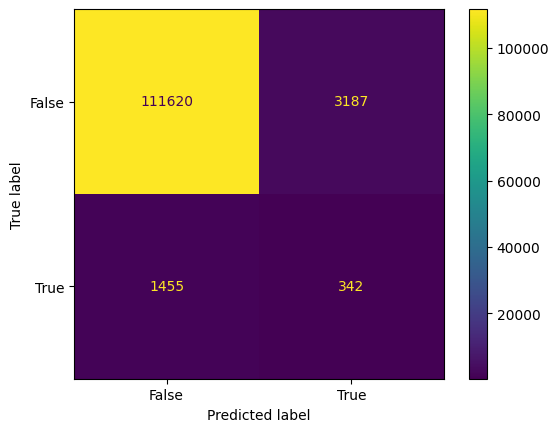

In [25]:
m1_test_results = test_metrics(model_1, x_test_scaled, y_test)

## Testing
Model 1 has been the best perfroming so I will test architecture for this one.

In [102]:
np.random.seed(33)
tf.random.set_seed(33)

model_14 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [103]:
model_14.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [104]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_14.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
17005/17005 [==============================] - 21s 1ms/step - loss: 0.0774 - binary_accuracy: 0.9844 - recall_15: 0.0000e+00 - precision_13: 0.0000e+00 - val_loss: 0.0725 - val_binary_accuracy: 0.9846 - val_recall_15: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 2/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0737 - binary_accuracy: 0.9846 - recall_15: 1.1925e-04 - precision_13: 0.3333 - val_loss: 0.0729 - val_binary_accuracy: 0.9846 - val_recall_15: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 3/10
17005/17005 [==============================] - 21s 1ms/step - loss: 0.0725 - binary_accuracy: 0.9846 - recall_15: 3.5774e-04 - precision_13: 0.5000 - val_loss: 0.0712 - val_binary_accuracy: 0.9846 - val_recall_15: 0.0000e+00 - val_precision_13: 0.0000e+00
Epoch 4/10
17005/17005 [==============================] - 21s 1ms/step - loss: 0.0718 - binary_accuracy: 0.9846 - recall_15: 8.3472e-04 - precision_13: 0.2800 - val_loss: 0.0715 - val_binary_accu

3644/3644 [==============================] - 2s 570us/step
Best Threshold: 0.08080808080808081
Accuracy: 0.9644866385372715
Precision: 0.10565275908479138
Recall: 0.17473567056204786
F1-Score: 0.13168379115118473
AUC: 0.7913182661556041
Confusion Matrix:
[[112149   2658]
 [  1483    314]]


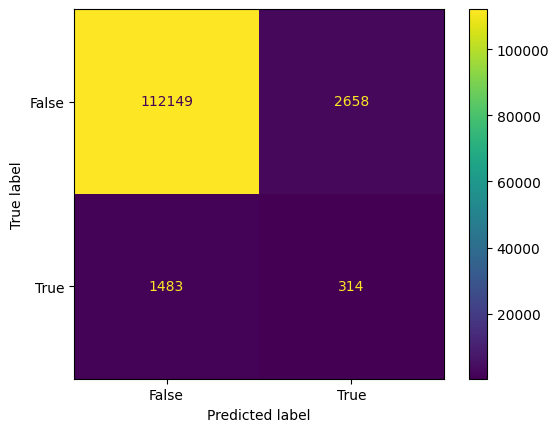

In [105]:
m14_test_results = test_metrics(model_14, x_test_scaled, y_test)

## Model Creation with SMOTE

In [83]:
np.random.seed(33)
tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [84]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train_resampled)
x_test_scaled = ct.transform(x_test)
x_val_scaled = ct.transform(x_val)

In [28]:
np.random.seed(33)
tf.random.set_seed(33)

model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [29]:
model_2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [30]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_2.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 29s 854us/step - loss: 0.1110 - binary_accuracy: 0.9590 - recall_1: 0.9391 - val_loss: 0.1035 - val_binary_accuracy: 0.9724 - val_recall_1: 0.0646
Epoch 2/10
33486/33486 [==============================] - 28s 836us/step - loss: 0.0800 - binary_accuracy: 0.9727 - recall_1: 0.9565 - val_loss: 0.0932 - val_binary_accuracy: 0.9758 - val_recall_1: 0.0523
Epoch 3/10
33486/33486 [==============================] - 28s 842us/step - loss: 0.0731 - binary_accuracy: 0.9756 - recall_1: 0.9608 - val_loss: 0.1229 - val_binary_accuracy: 0.9620 - val_recall_1: 0.1002
Epoch 4/10
33486/33486 [==============================] - 28s 840us/step - loss: 0.0696 - binary_accuracy: 0.9769 - recall_1: 0.9630 - val_loss: 0.0911 - val_binary_accuracy: 0.9775 - val_recall_1: 0.0306
Epoch 5/10
33486/33486 [==============================] - 28s 838us/step - loss: 0.0667 - binary_accuracy: 0.9782 - recall_1: 0.9648 - val_loss: 0.0828 - val_binary_accuracy: 0.981

3644/3644 [==============================] - 2s 472us/step
Best Threshold: 0.15151515151515152
Accuracy: 0.9363572433192686
Precision: 0.0580006287331028
Recall: 0.20534223706176963
F1-Score: 0.09045226130653267
AUC: 0.7446511342625927
Confusion Matrix:
[[108814   5993]
 [  1428    369]]


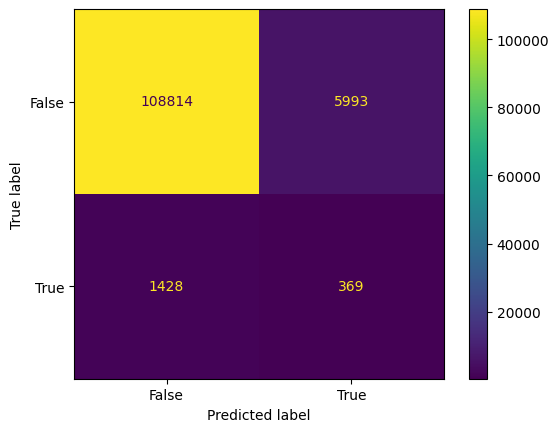

In [31]:
m2_test_results = test_metrics(model_2, x_test_scaled, y_test)

## Model 3
Using precision as a metric and SMOTE since it improved True positive rate

In [32]:
np.random.seed(33)
tf.random.set_seed(33)

model_3 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [33]:
model_3.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [34]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_3.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 30s 881us/step - loss: 0.1127 - binary_accuracy: 0.9585 - recall_2: 0.9384 - precision: 0.9776 - val_loss: 0.1146 - val_binary_accuracy: 0.9667 - val_recall_2: 0.0829 - val_precision: 0.0625
Epoch 2/10
33486/33486 [==============================] - 29s 867us/step - loss: 0.0790 - binary_accuracy: 0.9732 - recall_2: 0.9572 - precision: 0.9888 - val_loss: 0.1121 - val_binary_accuracy: 0.9665 - val_recall_2: 0.0890 - val_precision: 0.0660
Epoch 3/10
33486/33486 [==============================] - 29s 864us/step - loss: 0.0723 - binary_accuracy: 0.9760 - recall_2: 0.9611 - precision: 0.9907 - val_loss: 0.1202 - val_binary_accuracy: 0.9634 - val_recall_2: 0.0902 - val_precision: 0.0580
Epoch 4/10
33486/33486 [==============================] - 29s 871us/step - loss: 0.0683 - binary_accuracy: 0.9776 - recall_2: 0.9636 - precision: 0.9913 - val_loss: 0.1055 - val_binary_accuracy: 0.9707 - val_recall_2: 0.0545 - val_precision: 0.0539
Epoc

3644/3644 [==============================] - 2s 507us/step
Best Threshold: 0.14141414141414144
Accuracy: 0.9391701828410689
Precision: 0.06057085960836376
Recall: 0.20311630495269895
F1-Score: 0.09331458519749457
AUC: 0.7464442260430209
Confusion Matrix:
[[109146   5661]
 [  1432    365]]


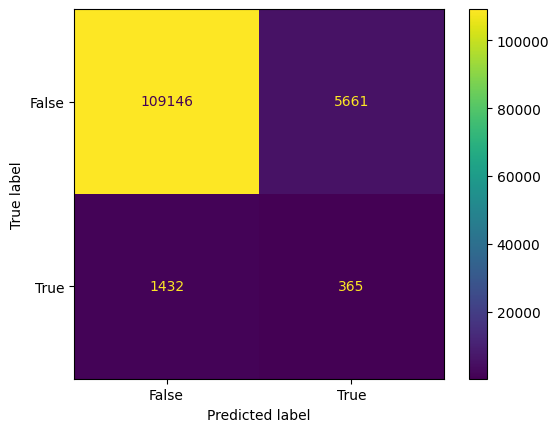

In [35]:
m3_test_results = test_metrics(model_3, x_test_scaled, y_test)

## Model 4
Model architecture changes.  
With SMOTE  
Adding two more hidden layers.  
Adding dropout layers  
Adding regularization to hidden layers.

In [36]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

np.random.seed(33)
tf.random.set_seed(33)

model_4 = Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1), input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [37]:
model_4.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [38]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_4.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 43s 1ms/step - loss: 0.7389 - binary_accuracy: 0.4995 - recall_3: 0.5073 - precision_1: 0.4995 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 43s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_3: 0.5265 - precision_1: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 43s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4998 - recall_3: 0.4784 - precision_1: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_precision_1: 0.0154
Epoch 4/10
33486/33486 [==============================] - 42s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4992 - recall_3: 0.5338 - precision_1: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_

3644/3644 [==============================] - 2s 541us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


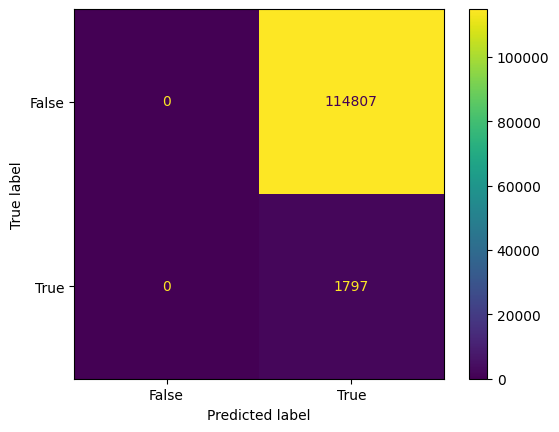

In [39]:
m4_test_results = test_metrics(model_4, x_test_scaled, y_test)

## Model 5
Previous model had too many changes.  
Reverting back to Model 3 arcitechture with only adding dropout layers.


In [40]:
np.random.seed(33)
tf.random.set_seed(33)

model_5 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [41]:
model_5.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [42]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_5.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 33s 975us/step - loss: 0.1445 - binary_accuracy: 0.9438 - recall_4: 0.9191 - precision_2: 0.9669 - val_loss: 0.1108 - val_binary_accuracy: 0.9745 - val_recall_4: 0.0540 - val_precision_2: 0.0709
Epoch 2/10
33486/33486 [==============================] - 32s 951us/step - loss: 0.1095 - binary_accuracy: 0.9602 - recall_4: 0.9382 - precision_2: 0.9814 - val_loss: 0.0915 - val_binary_accuracy: 0.9810 - val_recall_4: 0.0228 - val_precision_2: 0.0815
Epoch 3/10
33486/33486 [==============================] - 32s 965us/step - loss: 0.1034 - binary_accuracy: 0.9631 - recall_4: 0.9416 - precision_2: 0.9838 - val_loss: 0.1012 - val_binary_accuracy: 0.9819 - val_recall_4: 0.0206 - val_precision_2: 0.0959
Epoch 4/10
33486/33486 [==============================] - 32s 970us/step - loss: 0.0999 - binary_accuracy: 0.9646 - recall_4: 0.9439 - precision_2: 0.9848 - val_loss: 0.0957 - val_binary_accuracy: 0.9830 - val_recall_4: 0.0150 - val_precisio

3644/3644 [==============================] - 2s 591us/step
Best Threshold: 0.19191919191919193
Accuracy: 0.9280384892456519
Precision: 0.062151394422310755
Recall: 0.2604340567612688
F1-Score: 0.10035381151495658
AUC: 0.7316650567692713
Confusion Matrix:
[[107745   7062]
 [  1329    468]]


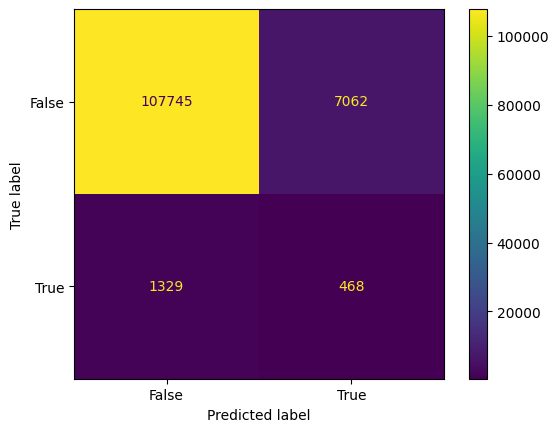

In [43]:
m5_test_results = test_metrics(model_5, x_test_scaled, y_test)

## Model 6
Adding an additional layer to model 3 arcitechture

In [44]:
np.random.seed(33)
tf.random.set_seed(33)

model_6 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model_6.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [46]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_6.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 31s 918us/step - loss: 0.1088 - binary_accuracy: 0.9600 - recall_5: 0.9389 - precision_3: 0.9803 - val_loss: 0.1250 - val_binary_accuracy: 0.9611 - val_recall_5: 0.0952 - val_precision_3: 0.0555
Epoch 2/10
33486/33486 [==============================] - 31s 916us/step - loss: 0.0789 - binary_accuracy: 0.9730 - recall_5: 0.9563 - precision_3: 0.9894 - val_loss: 0.1026 - val_binary_accuracy: 0.9717 - val_recall_5: 0.0662 - val_precision_3: 0.0685
Epoch 3/10
33486/33486 [==============================] - 30s 907us/step - loss: 0.0722 - binary_accuracy: 0.9759 - recall_5: 0.9606 - precision_3: 0.9910 - val_loss: 0.1024 - val_binary_accuracy: 0.9712 - val_recall_5: 0.0501 - val_precision_3: 0.0517
Epoch 4/10
33486/33486 [==============================] - 31s 918us/step - loss: 0.0687 - binary_accuracy: 0.9774 - recall_5: 0.9627 - precision_3: 0.9918 - val_loss: 0.0884 - val_binary_accuracy: 0.9789 - val_recall_5: 0.0295 - val_precisio

3644/3644 [==============================] - 2s 520us/step
Best Threshold: 0.14141414141414144
Accuracy: 0.9402764913725087
Precision: 0.06055451607416227
Recall: 0.19810795770728992
F1-Score: 0.09275664408546118
AUC: 0.759184629805685
Confusion Matrix:
[[109284   5523]
 [  1441    356]]


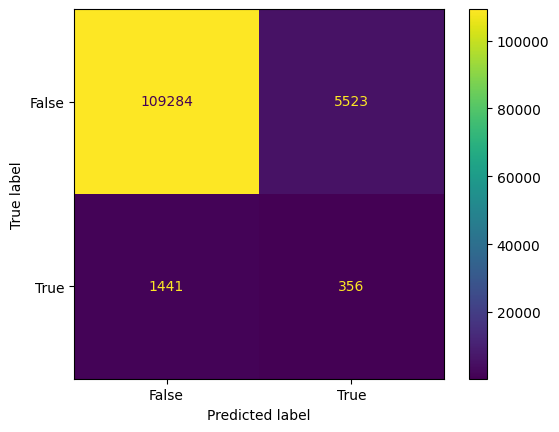

In [47]:
m6_test_results = test_metrics(model_6, x_test_scaled, y_test)

## Model 7
Attempt leakly Relu activation

In [48]:
np.random.seed(33)
tf.random.set_seed(33)

model_7 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(32),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [49]:
model_7.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [50]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_7.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 30s 880us/step - loss: 0.1163 - binary_accuracy: 0.9568 - recall_6: 0.9365 - precision_4: 0.9762 - val_loss: 0.1057 - val_binary_accuracy: 0.9729 - val_recall_6: 0.0623 - val_precision_4: 0.0704
Epoch 2/10
33486/33486 [==============================] - 29s 872us/step - loss: 0.0825 - binary_accuracy: 0.9719 - recall_6: 0.9550 - precision_4: 0.9883 - val_loss: 0.0965 - val_binary_accuracy: 0.9753 - val_recall_6: 0.0529 - val_precision_4: 0.0749
Epoch 3/10
33486/33486 [==============================] - 29s 867us/step - loss: 0.0748 - binary_accuracy: 0.9751 - recall_6: 0.9596 - precision_4: 0.9902 - val_loss: 0.1105 - val_binary_accuracy: 0.9678 - val_recall_6: 0.0846 - val_precision_4: 0.0673
Epoch 4/10
33486/33486 [==============================] - 29s 870us/step - loss: 0.0706 - binary_accuracy: 0.9767 - recall_6: 0.9623 - precision_4: 0.9909 - val_loss: 0.0964 - val_binary_accuracy: 0.9760 - val_recall_6: 0.0467 - val_precisio

3644/3644 [==============================] - 2s 490us/step
Best Threshold: 0.11111111111111112
Accuracy: 0.9180216802168022
Precision: 0.05329189686924494
Recall: 0.2576516416249304
F1-Score: 0.08831664282308059
AUC: 0.7333165036564062
Confusion Matrix:
[[106582   8225]
 [  1334    463]]


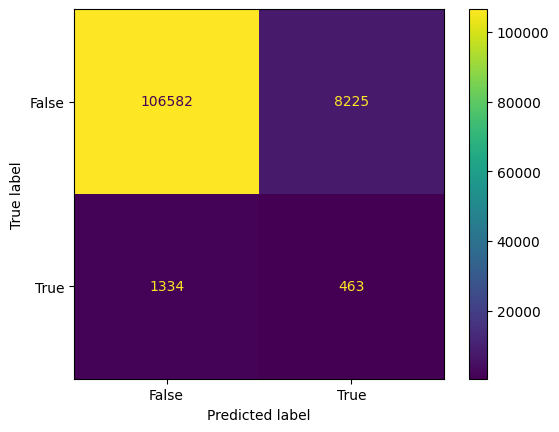

In [51]:
m7_test_results  = test_metrics(model_7, x_test_scaled, y_test)

## Model 8
Testing basic model architecture with biasas in fully connected layers

In [52]:
np.random.seed(33)
tf.random.set_seed(33)

model_8 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],), use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [53]:
model_8.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [54]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_8.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 32s 940us/step - loss: 0.1098 - binary_accuracy: 0.9597 - recall_7: 0.9390 - precision_5: 0.9796 - val_loss: 0.1062 - val_binary_accuracy: 0.9729 - val_recall_7: 0.0590 - val_precision_5: 0.0674
Epoch 2/10
33486/33486 [==============================] - 31s 913us/step - loss: 0.0791 - binary_accuracy: 0.9733 - recall_7: 0.9566 - precision_5: 0.9896 - val_loss: 0.1192 - val_binary_accuracy: 0.9647 - val_recall_7: 0.0985 - val_precision_5: 0.0662
Epoch 3/10
33486/33486 [==============================] - 31s 911us/step - loss: 0.0726 - binary_accuracy: 0.9758 - recall_7: 0.9606 - precision_5: 0.9906 - val_loss: 0.1026 - val_binary_accuracy: 0.9717 - val_recall_7: 0.0623 - val_precision_5: 0.0649
Epoch 4/10
33486/33486 [==============================] - 31s 922us/step - loss: 0.0684 - binary_accuracy: 0.9775 - recall_7: 0.9634 - precision_5: 0.9914 - val_loss: 0.0986 - val_binary_accuracy: 0.9745 - val_recall_7: 0.0406 - val_precisio

3644/3644 [==============================] - 2s 525us/step
Best Threshold: 0.15151515151515152
Accuracy: 0.9412284312716545
Precision: 0.06338514680483592
Recall: 0.2042292710072343
F1-Score: 0.09674443126400421
AUC: 0.7591527115364631
Confusion Matrix:
[[109384   5423]
 [  1430    367]]


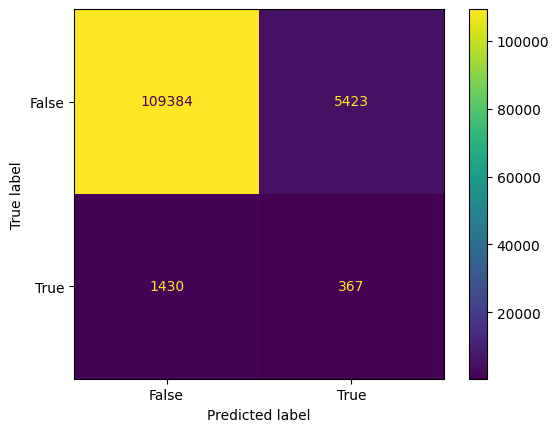

In [55]:
m8_test_results = test_metrics(model_8, x_test_scaled, y_test)

## Model 9
Using Model 5 architecture with bias

In [56]:
np.random.seed(33)
tf.random.set_seed(33)

model_9 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [57]:
model_9.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [58]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_9.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1453 - binary_accuracy: 0.9435 - recall_8: 0.9190 - precision_6: 0.9663 - val_loss: 0.1075 - val_binary_accuracy: 0.9759 - val_recall_8: 0.0584 - val_precision_6: 0.0860
Epoch 2/10
33486/33486 [==============================] - 33s 996us/step - loss: 0.1104 - binary_accuracy: 0.9597 - recall_8: 0.9381 - precision_6: 0.9804 - val_loss: 0.0920 - val_binary_accuracy: 0.9810 - val_recall_8: 0.0278 - val_precision_6: 0.0963
Epoch 3/10
33486/33486 [==============================] - 33s 986us/step - loss: 0.1035 - binary_accuracy: 0.9629 - recall_8: 0.9418 - precision_6: 0.9832 - val_loss: 0.0990 - val_binary_accuracy: 0.9807 - val_recall_8: 0.0289 - val_precision_6: 0.0935
Epoch 4/10
33486/33486 [==============================] - 33s 979us/step - loss: 0.0996 - binary_accuracy: 0.9649 - recall_8: 0.9447 - precision_6: 0.9844 - val_loss: 0.1016 - val_binary_accuracy: 0.9815 - val_recall_8: 0.0217 - val_precision_

3644/3644 [==============================] - 2s 525us/step
Best Threshold: 0.21212121212121213
Accuracy: 0.9337501286405269
Precision: 0.06437389770723104
Recall: 0.24373956594323873
F1-Score: 0.10184862225322637
AUC: 0.7327596958722611
Confusion Matrix:
[[108441   6366]
 [  1359    438]]


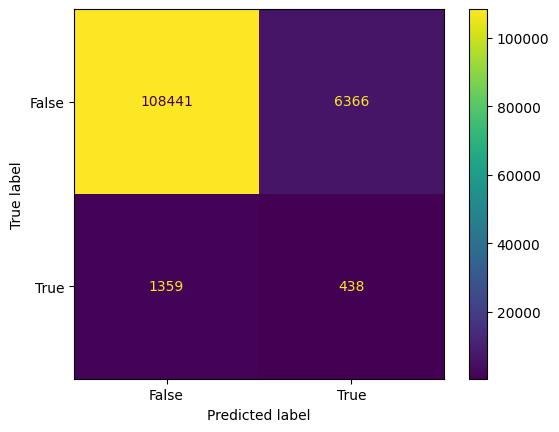

In [59]:
m9_test_results = test_metrics(model_9, x_test_scaled, y_test)

## Model 10
Same structure as 9 but with leaky relu instead

In [60]:
np.random.seed(33)
tf.random.set_seed(33)

model_10 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [61]:
model_10.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [62]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_10.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 34s 990us/step - loss: 0.1556 - binary_accuracy: 0.9382 - recall_9: 0.9105 - precision_7: 0.9639 - val_loss: 0.1192 - val_binary_accuracy: 0.9704 - val_recall_9: 0.0785 - val_precision_7: 0.0728
Epoch 2/10
33486/33486 [==============================] - 33s 986us/step - loss: 0.1258 - binary_accuracy: 0.9520 - recall_9: 0.9284 - precision_7: 0.9744 - val_loss: 0.0900 - val_binary_accuracy: 0.9818 - val_recall_9: 0.0245 - val_precision_7: 0.1076
Epoch 3/10
33486/33486 [==============================] - 33s 984us/step - loss: 0.1201 - binary_accuracy: 0.9547 - recall_9: 0.9324 - precision_7: 0.9760 - val_loss: 0.1102 - val_binary_accuracy: 0.9758 - val_recall_9: 0.0512 - val_precision_7: 0.0763
Epoch 4/10
33486/33486 [==============================] - 34s 1ms/step - loss: 0.1173 - binary_accuracy: 0.9562 - recall_9: 0.9343 - precision_7: 0.9770 - val_loss: 0.1153 - val_binary_accuracy: 0.9795 - val_recall_9: 0.0523 - val_precision_

3644/3644 [==============================] - 2s 516us/step
Best Threshold: 0.3535353535353536
Accuracy: 0.9470772872285685
Precision: 0.06863905325443787
Recall: 0.19365609348914858
F1-Score: 0.10135430318916558
AUC: 0.7447071766359781
Confusion Matrix:
[[110085   4722]
 [  1449    348]]


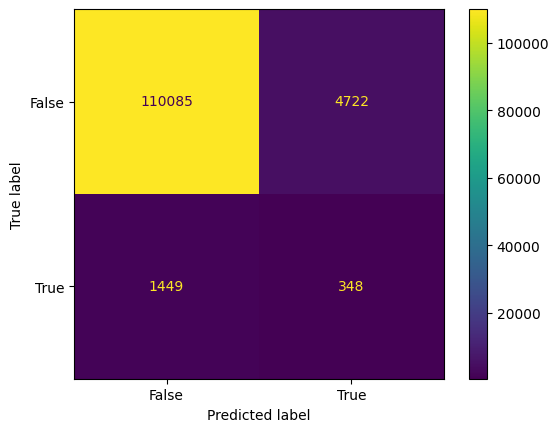

In [63]:
m10_test_results = test_metrics(model_10, x_test_scaled, y_test)

## Model 11
Adding another Dense layer

In [64]:
np.random.seed(33)
tf.random.set_seed(33)

model_11 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [65]:
model_11.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [66]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_11.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.1579 - binary_accuracy: 0.9373 - recall_10: 0.9075 - precision_8: 0.9650 - val_loss: 0.1141 - val_binary_accuracy: 0.9760 - val_recall_10: 0.0573 - val_precision_8: 0.0849
Epoch 2/10
33486/33486 [==============================] - 35s 1ms/step - loss: 0.1239 - binary_accuracy: 0.9536 - recall_10: 0.9290 - precision_8: 0.9770 - val_loss: 0.0998 - val_binary_accuracy: 0.9790 - val_recall_10: 0.0395 - val_precision_8: 0.0901
Epoch 3/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.1169 - binary_accuracy: 0.9568 - recall_10: 0.9332 - precision_8: 0.9793 - val_loss: 0.1096 - val_binary_accuracy: 0.9752 - val_recall_10: 0.0529 - val_precision_8: 0.0739
Epoch 4/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.1141 - binary_accuracy: 0.9581 - recall_10: 0.9355 - precision_8: 0.9799 - val_loss: 0.1151 - val_binary_accuracy: 0.9801 - val_recall_10: 0.0312 - val_precisio

3644/3644 [==============================] - 2s 534us/step
Best Threshold: 0.29292929292929293
Accuracy: 0.9401221227402148
Precision: 0.06639906338852651
Recall: 0.22092376182526433
F1-Score: 0.10210905349794239
AUC: 0.7384983801345073
Confusion Matrix:
[[109225   5582]
 [  1400    397]]


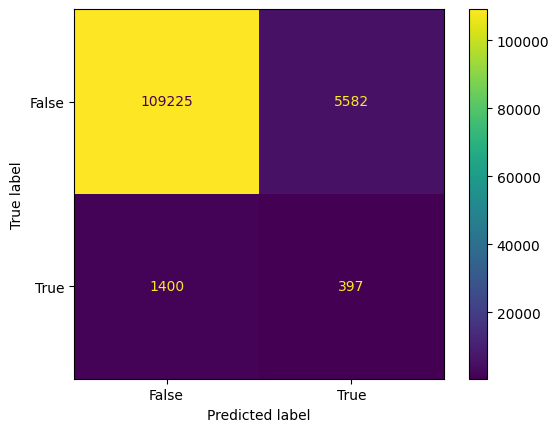

In [67]:
m11_test_results = test_metrics(model_11, x_test_scaled, y_test)

## Model 12
Adding L2 regularization

In [85]:
np.random.seed(33)
tf.random.set_seed(33)

model_12 = Sequential([
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.1), input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  kernel_regularizer=regularizers.l2(0.1), use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  kernel_regularizer=regularizers.l2(0.1), use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [86]:
model_12.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [87]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_12.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 41s 1ms/step - loss: 0.7231 - binary_accuracy: 0.5003 - recall_13: 0.5193 - precision_11: 0.5003 - val_loss: 0.6883 - val_binary_accuracy: 0.9846 - val_recall_13: 0.0000e+00 - val_precision_11: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4995 - recall_13: 0.5227 - precision_11: 0.4995 - val_loss: 0.6903 - val_binary_accuracy: 0.9846 - val_recall_13: 0.0000e+00 - val_precision_11: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4995 - recall_13: 0.4678 - precision_11: 0.4995 - val_loss: 0.7046 - val_binary_accuracy: 0.0154 - val_recall_13: 1.0000 - val_precision_11: 0.0154
Epoch 4/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_13: 0.5246 - precision_11: 0.4994 - val_loss: 0.7068 - val_binary_accuracy: 0.0154 - val_recall_13

3644/3644 [==============================] - 2s 565us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


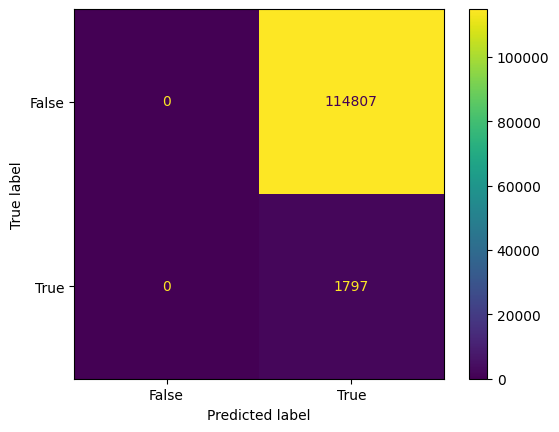

In [88]:
m12_test_results = test_metrics(model_12, x_test_scaled, y_test)

## Model 13
Adding More Dense Layers with Leaky Relu and removing L2 regularization

In [93]:
np.random.seed(33)
tf.random.set_seed(33)

model_13 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [94]:
model_13.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [95]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_13.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 41s 1ms/step - loss: 0.1609 - binary_accuracy: 0.9366 - recall_14: 0.9071 - precision_12: 0.9640 - val_loss: 0.1214 - val_binary_accuracy: 0.9741 - val_recall_14: 0.0751 - val_precision_12: 0.0904
Epoch 2/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.1256 - binary_accuracy: 0.9534 - recall_14: 0.9296 - precision_12: 0.9759 - val_loss: 0.1093 - val_binary_accuracy: 0.9725 - val_recall_14: 0.0812 - val_precision_12: 0.0860
Epoch 3/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.1190 - binary_accuracy: 0.9563 - recall_14: 0.9332 - precision_12: 0.9785 - val_loss: 0.1371 - val_binary_accuracy: 0.9565 - val_recall_14: 0.1369 - val_precision_12: 0.0653
Epoch 4/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.1144 - binary_accuracy: 0.9583 - recall_14: 0.9364 - precision_12: 0.9792 - val_loss: 0.1376 - val_binary_accuracy: 0.9623 - val_recall_14: 0.1258 - val_p

3644/3644 [==============================] - 2s 566us/step
Best Threshold: 0.5454545454545455
Accuracy: 0.9560649720421255
Precision: 0.0724935732647815
Recall: 0.15692821368948248
F1-Score: 0.09917355371900827
AUC: 0.7314954706667253
Confusion Matrix:
[[111199   3608]
 [  1515    282]]


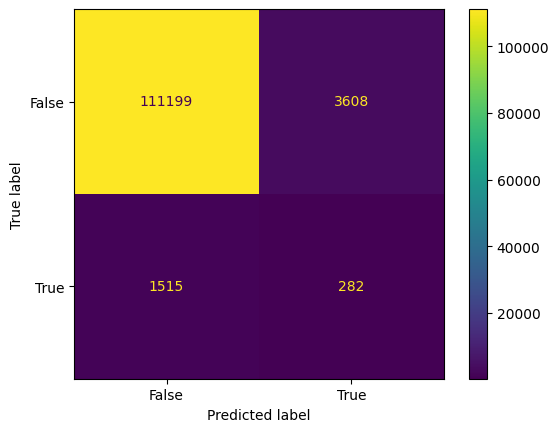

In [96]:
m13_test_results = test_metrics(model_13, x_test_scaled, y_test)

## Results ordering

In [106]:
all_results = {
    'model_1': m1_test_results,
    'model_2': m2_test_results,
    'model_3': m3_test_results,
    'model_4': m4_test_results,
    'model_5': m5_test_results,
    'model_6': m6_test_results,
    'model_7': m7_test_results,
    'model_8': m8_test_results,
    'model_9': m9_test_results,
    'model_10': m10_test_results,
    'model_11': m11_test_results,
    'model_12': m12_test_results,
    'model_13': m13_test_results,
    'model_14': m14_test_results,
}

In [107]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df

,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
model_1,0.080808,0.960190,0.096911,0.190317,0.128427,0.793724,"[[111620, 3187], [1455, 342]]"
model_2,0.151515,0.936357,0.058001,0.205342,0.090452,0.744651,"[[108814, 5993], [1428, 369]]"
model_3,0.141414,0.939170,0.060571,0.203116,0.093315,0.746444,"[[109146, 5661], [1432, 365]]"
model_4,0.000000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"
model_5,0.191919,0.928038,0.062151,0.260434,0.100354,0.731665,"[[107745, 7062], [1329, 468]]"
model_6,0.141414,0.940276,0.060555,0.198108,0.092757,0.759185,"[[109284, 5523], [1441, 356]]"
model_7,0.111111,0.918022,0.053292,0.257652,0.088317,0.733317,"[[106582, 8225], [1334, 463]]"
model_8,0.151515,0.941228,0.063385,0.204229,0.096744,0.759153,"[[109384, 5423], [1430, 367]]"
model_9,0.212121,0.933750,0.064374,0.243740,0.101849,0.732760,"[[108441, 6366], [1359, 438]]"
model_10,0.353535,0.947077,0.068639,0.193656,0.101354,0.744707,"[[110085, 4722], [1449, 348]]"


In [108]:
sorted_df = results_df.sort_values(by='F1-Score', ascending=False)
sorted_df

,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
model_14,0.080808,0.964487,0.105653,0.174736,0.131684,0.791318,"[[112149, 2658], [1483, 314]]"
model_1,0.080808,0.960190,0.096911,0.190317,0.128427,0.793724,"[[111620, 3187], [1455, 342]]"
model_11,0.292929,0.940122,0.066399,0.220924,0.102109,0.738498,"[[109225, 5582], [1400, 397]]"
model_9,0.212121,0.933750,0.064374,0.243740,0.101849,0.732760,"[[108441, 6366], [1359, 438]]"
model_10,0.353535,0.947077,0.068639,0.193656,0.101354,0.744707,"[[110085, 4722], [1449, 348]]"
model_5,0.191919,0.928038,0.062151,0.260434,0.100354,0.731665,"[[107745, 7062], [1329, 468]]"
model_13,0.545455,0.956065,0.072494,0.156928,0.099174,0.731495,"[[111199, 3608], [1515, 282]]"
model_8,0.151515,0.941228,0.063385,0.204229,0.096744,0.759153,"[[109384, 5423], [1430, 367]]"
model_3,0.141414,0.939170,0.060571,0.203116,0.093315,0.746444,"[[109146, 5661], [1432, 365]]"
model_6,0.141414,0.940276,0.060555,0.198108,0.092757,0.759185,"[[109284, 5523], [1441, 356]]"


## RNN Model
First attempt with a simple architecture.

In [75]:

embedding_dim = 32
max_features = int(np.max(x_train_scaled)) + 1

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [76]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [77]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_r1.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_11/embedding/embedding_lookup' defined at (most recent call last):
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "C:\Users\brian\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\brian\AppData\Local\Temp\ipykernel_21116\3956798898.py", line 4, in <module>
      history = model_r1.fit(x_train_scaled, y_train_resampled,
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\brian\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\layers\core\embedding.py", line 208, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential_11/embedding/embedding_lookup'
indices[11,7] = -1 is not in [0, 12)
	 [[{{node sequential_11/embedding/embedding_lookup}}]] [Op:__inference_train_function_23278997]

In [ ]:
test_metrics(model_r1, x_test_scaled, y_test)

In [ ]:
negative_indices = np.any(x_train_scaled < 0 , axis=1)

# Print the rows in x_train_scaled where any value is -1
for index, has_negative in enumerate(negative_indices):
    if has_negative:
        print(f"Row {index} with -1 values:", x_train_scaled[index])